In [1]:
import torch 
import torch.nn as nn
import os,glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

In [3]:
df1 = pd.read_csv("./C5-C129/all_fished_with_labels/effected_compounds_fishes_labeled.csv")
df1

,index,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3,action mode
0,C27_00,0.028764,0.068646,0.028082,0.298368,0.050132,0.278168,0.037783,0.130060,0.031555,0.034696,0.031200,0.033734,0.031431,0.034636,GABAA allosteric antagonist
1,C27_01,0.034007,0.037104,0.036158,0.292708,0.046303,0.241568,0.036107,0.038092,0.033519,0.034894,0.034084,0.035500,0.033933,0.036275,GABAA allosteric antagonist
2,C27_02,0.021472,0.070414,0.015166,0.017657,0.012417,0.015186,0.010722,0.012020,0.010183,0.010478,0.010575,0.010774,0.009926,0.010305,GABAA allosteric antagonist
3,C27_03,0.032434,0.044575,0.031910,0.582665,0.042110,0.161612,0.020669,0.040788,0.017505,0.018032,0.017628,0.018242,0.019698,0.020793,GABAA allosteric antagonist
4,C27_04,0.026860,0.051772,0.028082,0.298368,0.050132,0.278168,0.037783,0.130060,0.031555,0.034696,0.031200,0.033734,0.031431,0.034636,GABAA allosteric antagonist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,WT_Control_39_06,0.029762,0.030940,0.032357,0.043304,0.032474,0.087818,0.028630,0.030874,0.028339,0.029058,0.028269,0.029104,0.033801,0.035754,WT_control
4799,WT_Control_39_07,0.025772,0.028487,0.139233,0.289870,0.053855,0.103895,0.027061,0.038182,0.025958,0.027907,0.025788,0.027966,0.025757,0.027941,WT_control
4800,WT_Control_39_08,0.032075,0.033806,0.054066,0.285480,0.036312,0.105165,0.032086,0.037296,0.030585,0.031808,0.030598,0.031539,0.030454,0.031774,WT_control
4801,WT_Control_39_09,0.019190,0.019578,0.030485,0.098099,0.031112,0.065068,0.020729,0.035798,0.020431,0.020886,0.020524,0.020836,0.020473,0.020871,WT_control


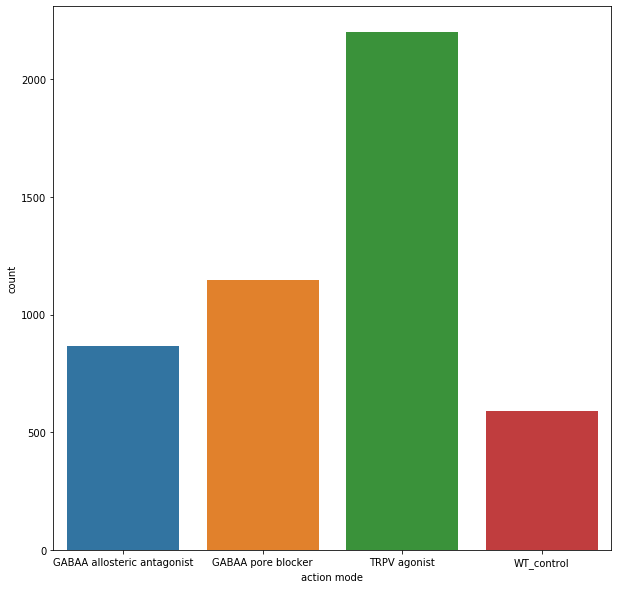

In [4]:
plt.figure(figsize=(10, 10))
sns.countplot(x='action mode', data=df1)
plt.savefig("./effected compounds(32hpf)/four_distribution_allfihes.png", dpi=300)

In [5]:
le=LabelEncoder()
X=df.iloc[:, 1:-1]
Y=le.fit_transform(df['action mode'])

In [6]:
class2idx = {
    'GABAA allosteric antagonist':0,
    'GABAA pore blocker':1,
    'TRPV agonist':2,
    'WT_control':3,
}

idx2class = {v: k for k, v in class2idx.items()}

df['action mode'].replace(class2idx, inplace=True)

In [7]:
X

,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,0.028764,0.068646,0.028082,0.298368,0.050132,0.278168,0.037783,0.130060,0.031555,0.034696,0.031200,0.033734,0.031431,0.034636
1,0.034007,0.037104,0.036158,0.292708,0.046303,0.241568,0.036107,0.038092,0.033519,0.034894,0.034084,0.035500,0.033933,0.036275
2,0.021472,0.070414,0.015166,0.017657,0.012417,0.015186,0.010722,0.012020,0.010183,0.010478,0.010575,0.010774,0.009926,0.010305
3,0.032434,0.044575,0.031910,0.582665,0.042110,0.161612,0.020669,0.040788,0.017505,0.018032,0.017628,0.018242,0.019698,0.020793
4,0.026860,0.051772,0.028082,0.298368,0.050132,0.278168,0.037783,0.130060,0.031555,0.034696,0.031200,0.033734,0.031431,0.034636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.029762,0.030940,0.032357,0.043304,0.032474,0.087818,0.028630,0.030874,0.028339,0.029058,0.028269,0.029104,0.033801,0.035754
4799,0.025772,0.028487,0.139233,0.289870,0.053855,0.103895,0.027061,0.038182,0.025958,0.027907,0.025788,0.027966,0.025757,0.027941
4800,0.032075,0.033806,0.054066,0.285480,0.036312,0.105165,0.032086,0.037296,0.030585,0.031808,0.030598,0.031539,0.030454,0.031774
4801,0.019190,0.019578,0.030485,0.098099,0.031112,0.065068,0.020729,0.035798,0.020431,0.020886,0.020524,0.020836,0.020473,0.020871


In [8]:
Y.shape

(4803,)

In [9]:
le.classes_

array(['GABAA allosteric antagonist', 'GABAA pore blocker',
       'TRPV agonist', 'WT_control'], dtype=object)

In [10]:
le.inverse_transform([0,1,2,3])
dict(zip(le.inverse_transform([0,1,2,3]),[0,1,2,3]))

{'GABAA allosteric antagonist': 0,
 'GABAA pore blocker': 1,
 'TRPV agonist': 2,
 'WT_control': 3}

In [11]:

#Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=21)

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

In [13]:
def get_class_distribution(obj):
    count_dict = {
        "GABAA allosteric antagonist_": 0,
        "GABAA pore blocker_": 0,
        "TRPV agonist_": 0,
        "WT_control": 0,

    }
    
    for i in obj:
        if i == 0: 
            count_dict['GABAA allosteric antagonist_'] += 1
        elif i == 1: 
            count_dict['GABAA pore blocker_'] += 1
        elif i == 2: 
            count_dict['TRPV agonist_'] += 1 
        elif i == 3: 
            count_dict['WT_control'] += 1  
        else:
            print("Check classes.")
            
    return count_dict


Once we have the dictionary count, we use Seaborn library to plot the bar charts. The make the plot, we first convert our dictionary to a dataframe using pd.DataFrame.from_dict([get_class_distribution(y_train)]) . Subsequently, we .melt() our convert our dataframe into the long format and finally use sns.barplot() to build the plots.

Text(0.5, 1.0, 'Class Distribution in Val Set')

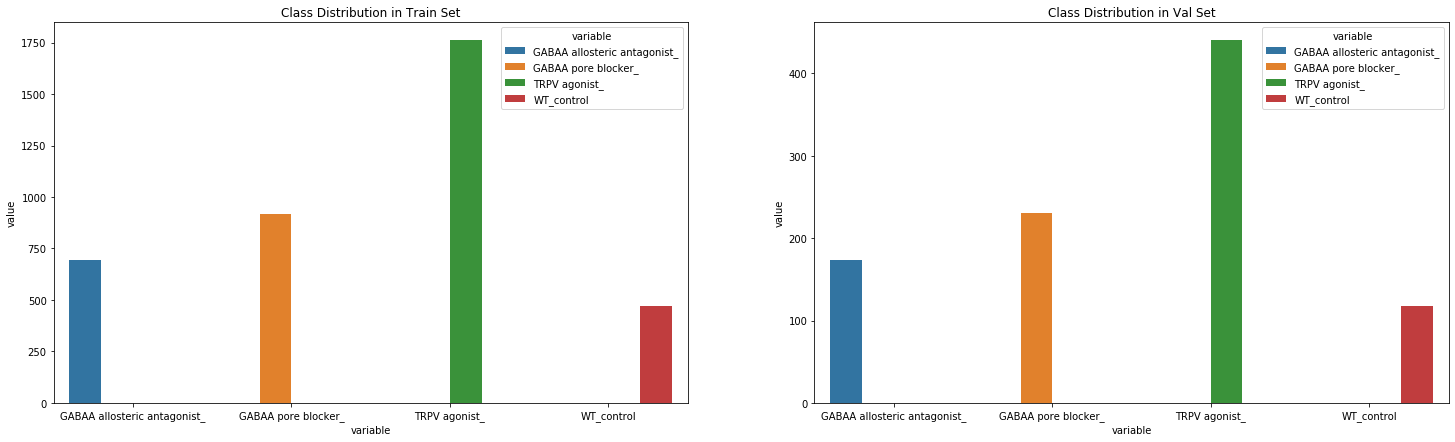

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')


In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

In [16]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [17]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


tensor([0.0014, 0.0011, 0.0006, 0.0021])


In [18]:
class_weights_all = class_weights[target_list]

In [19]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [20]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.00007

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 4

In [21]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

In [22]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)



MulticlassClassification(
  (layer_1): Linear(in_features=14, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [25]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [26]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [27]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


Epoch 001: | Train Loss: 1.38907 | Val Loss: 1.35428 | Train Acc: 27.809| Val Acc: 35.796
Epoch 002: | Train Loss: 1.32653 | Val Loss: 1.34838 | Train Acc: 36.066| Val Acc: 33.403
Epoch 003: | Train Loss: 1.32173 | Val Loss: 1.31208 | Train Acc: 35.041| Val Acc: 38.085
Epoch 004: | Train Loss: 1.30544 | Val Loss: 1.31357 | Train Acc: 37.274| Val Acc: 36.629
Epoch 005: | Train Loss: 1.29969 | Val Loss: 1.32272 | Train Acc: 37.481| Val Acc: 39.334
Epoch 006: | Train Loss: 1.28995 | Val Loss: 1.26403 | Train Acc: 38.656| Val Acc: 45.578
Epoch 007: | Train Loss: 1.28129 | Val Loss: 1.28299 | Train Acc: 38.461| Val Acc: 41.727
Epoch 008: | Train Loss: 1.27927 | Val Loss: 1.32132 | Train Acc: 39.485| Val Acc: 36.212
Epoch 009: | Train Loss: 1.27038 | Val Loss: 1.29350 | Train Acc: 39.963| Val Acc: 37.773
Epoch 010: | Train Loss: 1.26621 | Val Loss: 1.26843 | Train Acc: 39.087| Val Acc: 41.935
Epoch 011: | Train Loss: 1.27685 | Val Loss: 1.25600 | Train Acc: 38.382| Val Acc: 44.745
Epoch 012:

Epoch 093: | Train Loss: 1.17095 | Val Loss: 1.28121 | Train Acc: 45.008| Val Acc: 39.958
Epoch 094: | Train Loss: 1.18652 | Val Loss: 1.26381 | Train Acc: 44.622| Val Acc: 41.519
Epoch 095: | Train Loss: 1.16675 | Val Loss: 1.24666 | Train Acc: 45.344| Val Acc: 42.560
Epoch 096: | Train Loss: 1.17355 | Val Loss: 1.26344 | Train Acc: 45.274| Val Acc: 38.710
Epoch 097: | Train Loss: 1.16987 | Val Loss: 1.28771 | Train Acc: 45.909| Val Acc: 37.773
Epoch 098: | Train Loss: 1.17847 | Val Loss: 1.26797 | Train Acc: 44.892| Val Acc: 40.999
Epoch 099: | Train Loss: 1.16915 | Val Loss: 1.26965 | Train Acc: 46.324| Val Acc: 39.022
Epoch 100: | Train Loss: 1.15521 | Val Loss: 1.26478 | Train Acc: 45.817| Val Acc: 43.392
Epoch 101: | Train Loss: 1.17901 | Val Loss: 1.26147 | Train Acc: 45.461| Val Acc: 40.375
Epoch 102: | Train Loss: 1.17141 | Val Loss: 1.30470 | Train Acc: 44.477| Val Acc: 35.484
Epoch 103: | Train Loss: 1.17242 | Val Loss: 1.26768 | Train Acc: 46.527| Val Acc: 44.641
Epoch 104:

Epoch 185: | Train Loss: 1.09491 | Val Loss: 1.27713 | Train Acc: 49.556| Val Acc: 41.415
Epoch 186: | Train Loss: 1.09546 | Val Loss: 1.29221 | Train Acc: 49.734| Val Acc: 41.831
Epoch 187: | Train Loss: 1.10713 | Val Loss: 1.33001 | Train Acc: 49.116| Val Acc: 35.484
Epoch 188: | Train Loss: 1.11768 | Val Loss: 1.33517 | Train Acc: 47.768| Val Acc: 38.085
Epoch 189: | Train Loss: 1.12776 | Val Loss: 1.32710 | Train Acc: 47.328| Val Acc: 36.316
Epoch 190: | Train Loss: 1.10129 | Val Loss: 1.27663 | Train Acc: 48.448| Val Acc: 45.578
Epoch 191: | Train Loss: 1.09788 | Val Loss: 1.30125 | Train Acc: 47.946| Val Acc: 40.583
Epoch 192: | Train Loss: 1.12398 | Val Loss: 1.27858 | Train Acc: 47.606| Val Acc: 41.207
Epoch 193: | Train Loss: 1.10012 | Val Loss: 1.28409 | Train Acc: 50.320| Val Acc: 40.375
Epoch 194: | Train Loss: 1.11679 | Val Loss: 1.27517 | Train Acc: 49.365| Val Acc: 45.161
Epoch 195: | Train Loss: 1.10220 | Val Loss: 1.26455 | Train Acc: 48.461| Val Acc: 46.826
Epoch 196:

Epoch 277: | Train Loss: 1.06907 | Val Loss: 1.30052 | Train Acc: 50.834| Val Acc: 42.456
Epoch 278: | Train Loss: 1.07305 | Val Loss: 1.33997 | Train Acc: 50.386| Val Acc: 39.750
Epoch 279: | Train Loss: 1.07673 | Val Loss: 1.31025 | Train Acc: 50.083| Val Acc: 41.623
Epoch 280: | Train Loss: 1.04322 | Val Loss: 1.27697 | Train Acc: 51.954| Val Acc: 42.664
Epoch 281: | Train Loss: 1.06246 | Val Loss: 1.33129 | Train Acc: 50.046| Val Acc: 42.144
Epoch 282: | Train Loss: 1.06965 | Val Loss: 1.32567 | Train Acc: 51.456| Val Acc: 42.248
Epoch 283: | Train Loss: 1.05899 | Val Loss: 1.26733 | Train Acc: 51.461| Val Acc: 46.930
Epoch 284: | Train Loss: 1.07407 | Val Loss: 1.31080 | Train Acc: 51.813| Val Acc: 44.537
Epoch 285: | Train Loss: 1.05710 | Val Loss: 1.32162 | Train Acc: 51.158| Val Acc: 39.958
Epoch 286: | Train Loss: 1.05700 | Val Loss: 1.30256 | Train Acc: 51.959| Val Acc: 45.890
Epoch 287: | Train Loss: 1.05428 | Val Loss: 1.31405 | Train Acc: 51.394| Val Acc: 40.999
Epoch 288:

## Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

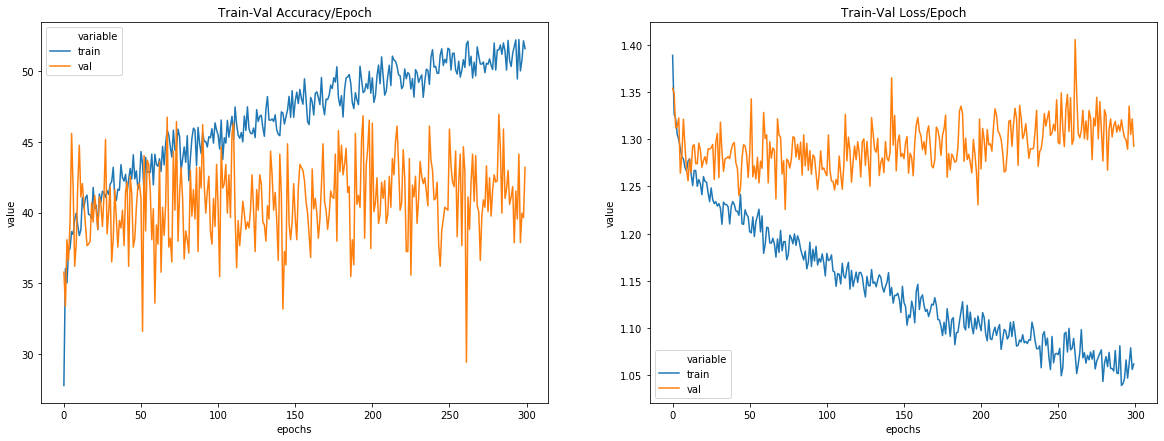

In [28]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Test the model

### test the new PMR data 

In [29]:
test = pd.read_csv('testset_withoutWT.csv')
test

,Unnamed: 0,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,C1,0.022760,0.025234,0.022922,0.024524,0.023107,0.025042,0.023016,0.025137,0.022669,0.024411,0.022702,0.024123,0.022598,0.024094
1,C4,0.022256,0.025216,0.023978,0.025251,0.025146,0.028801,0.023876,0.027436,0.022252,0.023942,0.022336,0.024188,0.022134,0.023785
2,C6,0.020297,0.023361,0.020478,0.023386,0.020434,0.024109,0.020014,0.023165,0.020023,0.022575,0.020586,0.024104,0.020184,0.022914
3,C7,0.017919,0.019106,0.017926,0.018954,0.017931,0.019289,0.017930,0.018902,0.017882,0.018874,0.017785,0.018622,0.017812,0.018926
4,C8,0.023799,0.026014,0.023703,0.026203,0.023647,0.034638,0.023850,0.030160,0.022710,0.023964,0.022531,0.024691,0.022432,0.023973
5,C14,0.018832,0.021502,0.020516,0.021909,0.019814,0.021256,0.019850,0.022207,0.018725,0.019542,0.018465,0.018842,0.018992,0.019440
6,C16,0.016205,0.017040,0.016681,0.017017,0.016449,0.017081,0.016356,0.016746,0.016249,0.016514,0.016251,0.016534,0.016235,0.016543
7,C18,0.018422,0.021137,0.018822,0.020312,0.021269,0.032057,0.019213,0.021578,0.018676,0.019631,0.018573,0.019775,0.018291,0.019668
8,C19,0.021406,0.024408,0.021994,0.023836,0.022794,0.030129,0.021468,0.024629,0.020861,0.021710,0.020622,0.021531,0.020423,0.021841
9,C32,0.015425,0.017852,0.015560,0.017427,0.015485,0.017377,0.015305,0.016626,0.015414,0.016805,0.015285,0.016545,0.015240,0.016774


In [30]:
Test = test.iloc[:, 1:]
Test

,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,0.022760,0.025234,0.022922,0.024524,0.023107,0.025042,0.023016,0.025137,0.022669,0.024411,0.022702,0.024123,0.022598,0.024094
1,0.022256,0.025216,0.023978,0.025251,0.025146,0.028801,0.023876,0.027436,0.022252,0.023942,0.022336,0.024188,0.022134,0.023785
2,0.020297,0.023361,0.020478,0.023386,0.020434,0.024109,0.020014,0.023165,0.020023,0.022575,0.020586,0.024104,0.020184,0.022914
3,0.017919,0.019106,0.017926,0.018954,0.017931,0.019289,0.017930,0.018902,0.017882,0.018874,0.017785,0.018622,0.017812,0.018926
4,0.023799,0.026014,0.023703,0.026203,0.023647,0.034638,0.023850,0.030160,0.022710,0.023964,0.022531,0.024691,0.022432,0.023973
5,0.018832,0.021502,0.020516,0.021909,0.019814,0.021256,0.019850,0.022207,0.018725,0.019542,0.018465,0.018842,0.018992,0.019440
6,0.016205,0.017040,0.016681,0.017017,0.016449,0.017081,0.016356,0.016746,0.016249,0.016514,0.016251,0.016534,0.016235,0.016543
7,0.018422,0.021137,0.018822,0.020312,0.021269,0.032057,0.019213,0.021578,0.018676,0.019631,0.018573,0.019775,0.018291,0.019668
8,0.021406,0.024408,0.021994,0.023836,0.022794,0.030129,0.021468,0.024629,0.020861,0.021710,0.020622,0.021531,0.020423,0.021841
9,0.015425,0.017852,0.015560,0.017427,0.015485,0.017377,0.015305,0.016626,0.015414,0.016805,0.015285,0.016545,0.015240,0.016774


In [31]:
Y_test = np.zeros(13)

In [32]:
Y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
scaler = MinMaxScaler()
Test = scaler.fit_transform(Test)
Test, Y_test = np.array(Test), np.array(Y_test)

In [34]:
Test_dataset = ClassifierDataset(torch.from_numpy(Test).float(), torch.from_numpy(Y_test).long())

In [35]:
Test_loader = DataLoader(dataset=Test_dataset, batch_size=1)
for i in Test_loader:
    print(i)

[tensor([[0.8760, 0.7057, 0.8746, 0.7776, 0.4725, 0.0663, 0.8996, 0.6289, 0.9944,
         1.0000, 1.0000, 0.7998, 1.0000, 0.9411]]), tensor([0])]
[tensor([[0.8158, 0.7042, 1.0000, 0.8529, 0.5989, 0.0976, 1.0000, 0.7987, 0.9372,
         0.9406, 0.9507, 0.8066, 0.9370, 0.9025]]), tensor([0])]
[tensor([[0.5819, 0.5444, 0.5842, 0.6597, 0.3068, 0.0585, 0.5494, 0.4832, 0.6317,
         0.7675, 0.7147, 0.7978, 0.6719, 0.7940]]), tensor([0])]
[tensor([[0.2979, 0.1780, 0.2810, 0.2006, 0.1517, 0.0184, 0.3062, 0.1682, 0.3383,
         0.2988, 0.3371, 0.2200, 0.3496, 0.2970]]), tensor([0])]
[tensor([[1.0000, 0.7729, 0.9673, 0.9515, 0.5060, 0.1462, 0.9969, 1.0000, 1.0000,
         0.9434, 0.9769, 0.8596, 0.9774, 0.9259]]), tensor([0])]
[tensor([[0.4069, 0.3843, 0.5887, 0.5067, 0.2684, 0.0348, 0.5302, 0.4124, 0.4538,
         0.3834, 0.4288, 0.2432, 0.5100, 0.3610]]), tensor([0])]
[tensor([[0.0932, 0.0000, 0.1332, 0.0000, 0.0598, 0.0000, 0.1226, 0.0089, 0.1144,
         0.0000, 0.1303, 0.0000, 0.1

In [36]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in Test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [37]:
y_pred_list

[2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2]

In [38]:
le.inverse_transform(y_pred_list)

array(['TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'TRPV agonist',
       'TRPV agonist', 'TRPV agonist', 'GABAA pore blocker',
       'TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'WT_control',
       'TRPV agonist', 'TRPV agonist'], dtype=object)

In [39]:
# test again


In [40]:
test = pd.read_csv('testset.csv')
test

,Unnamed: 0,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,C1,0.022760,0.025234,0.022922,0.024524,0.023107,0.025042,0.023016,0.025137,0.022669,0.024411,0.022702,0.024123,0.022598,0.024094
1,C4,0.022256,0.025216,0.023978,0.025251,0.025146,0.028801,0.023876,0.027436,0.022252,0.023942,0.022336,0.024188,0.022134,0.023785
2,C6,0.020297,0.023361,0.020478,0.023386,0.020434,0.024109,0.020014,0.023165,0.020023,0.022575,0.020586,0.024104,0.020184,0.022914
3,C7,0.017919,0.019106,0.017926,0.018954,0.017931,0.019289,0.017930,0.018902,0.017882,0.018874,0.017785,0.018622,0.017812,0.018926
4,C8,0.023799,0.026014,0.023703,0.026203,0.023647,0.034638,0.023850,0.030160,0.022710,0.023964,0.022531,0.024691,0.022432,0.023973
5,C14,0.018832,0.021502,0.020516,0.021909,0.019814,0.021256,0.019850,0.022207,0.018725,0.019542,0.018465,0.018842,0.018992,0.019440
6,C16,0.016205,0.017040,0.016681,0.017017,0.016449,0.017081,0.016356,0.016746,0.016249,0.016514,0.016251,0.016534,0.016235,0.016543
7,C18,0.018422,0.021137,0.018822,0.020312,0.021269,0.032057,0.019213,0.021578,0.018676,0.019631,0.018573,0.019775,0.018291,0.019668
8,C19,0.021406,0.024408,0.021994,0.023836,0.022794,0.030129,0.021468,0.024629,0.020861,0.021710,0.020622,0.021531,0.020423,0.021841
9,C32,0.015425,0.017852,0.015560,0.017427,0.015485,0.017377,0.015305,0.016626,0.015414,0.016805,0.015285,0.016545,0.015240,0.016774


In [41]:
Test = test.iloc[:, 1:]
Test

,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,0.022760,0.025234,0.022922,0.024524,0.023107,0.025042,0.023016,0.025137,0.022669,0.024411,0.022702,0.024123,0.022598,0.024094
1,0.022256,0.025216,0.023978,0.025251,0.025146,0.028801,0.023876,0.027436,0.022252,0.023942,0.022336,0.024188,0.022134,0.023785
2,0.020297,0.023361,0.020478,0.023386,0.020434,0.024109,0.020014,0.023165,0.020023,0.022575,0.020586,0.024104,0.020184,0.022914
3,0.017919,0.019106,0.017926,0.018954,0.017931,0.019289,0.017930,0.018902,0.017882,0.018874,0.017785,0.018622,0.017812,0.018926
4,0.023799,0.026014,0.023703,0.026203,0.023647,0.034638,0.023850,0.030160,0.022710,0.023964,0.022531,0.024691,0.022432,0.023973
5,0.018832,0.021502,0.020516,0.021909,0.019814,0.021256,0.019850,0.022207,0.018725,0.019542,0.018465,0.018842,0.018992,0.019440
6,0.016205,0.017040,0.016681,0.017017,0.016449,0.017081,0.016356,0.016746,0.016249,0.016514,0.016251,0.016534,0.016235,0.016543
7,0.018422,0.021137,0.018822,0.020312,0.021269,0.032057,0.019213,0.021578,0.018676,0.019631,0.018573,0.019775,0.018291,0.019668
8,0.021406,0.024408,0.021994,0.023836,0.022794,0.030129,0.021468,0.024629,0.020861,0.021710,0.020622,0.021531,0.020423,0.021841
9,0.015425,0.017852,0.015560,0.017427,0.015485,0.017377,0.015305,0.016626,0.015414,0.016805,0.015285,0.016545,0.015240,0.016774


In [42]:
Y_test = np.zeros(17)

In [43]:
scaler = MinMaxScaler()
Test = scaler.fit_transform(Test)
Test, Y_test = np.array(Test), np.array(Y_test)

Test_dataset = ClassifierDataset(torch.from_numpy(Test).float(), torch.from_numpy(Y_test).long())

Test_loader = DataLoader(dataset=Test_dataset, batch_size=1)

y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in Test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [44]:
y_pred_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2]

In [45]:
le.inverse_transform(y_pred_list)

array(['TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'TRPV agonist',
       'TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'TRPV agonist',
       'TRPV agonist', 'WT_control', 'WT_control', 'TRPV agonist',
       'TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'TRPV agonist',
       'TRPV agonist'], dtype=object)

In [48]:
test["prediction of action mode"] = le.inverse_transform(y_pred_list)

In [52]:
test.to_csv("prediction of action mode(all fishes).csv", index=None)